# Anomaly Detection - Isolation Forests

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
from sklearn.ensemble import IsolationForest

import seaborn
from scipy.spatial.distance import pdist, squareform

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
cyclists_dataset = pd.read_csv('../data/cyclists_dataset_fe.csv', dtype={'cyclist_team': str})
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cyclist_url      6095 non-null   object 
 1   mean_cyclist_cp  5011 non-null   float64
 2   mean_delta       6095 non-null   float64
 3   mean_position    6095 non-null   float64
 4   birth_year       6095 non-null   int64  
 5   weight           3134 non-null   float64
 6   height           3134 non-null   float64
 7   nationality      6095 non-null   object 
 8   cyclist_name     6095 non-null   object 
 9   cyclist_bmi      3134 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 476.3+ KB


In [3]:
races_dataset = pd.read_csv('../data/races_dataset_fe.csv')
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')
races_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   race_url              5281 non-null   object        
 1   race_name             5281 non-null   object        
 2   points                5281 non-null   float64       
 3   uci_points            2780 non-null   float64       
 4   length                5281 non-null   float64       
 5   climb_total           3326 non-null   float64       
 6   profile               3326 non-null   float64       
 7   startlist_quality     5281 non-null   int64         
 8   date                  5281 non-null   datetime64[ns]
 9   mostly_tarmac         5281 non-null   bool          
 10  race_year             5281 non-null   int64         
 11  race_stage            5281 non-null   object        
 12  race_season           5281 non-null   object        
 13  climb_percentage  

In [4]:
complete_dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
complete_dataset['date'] = pd.to_datetime(complete_dataset['date'], format='%Y-%m-%d')
complete_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   cyclist_url                  589739 non-null  object        
 1   cyclist_name                 589739 non-null  object        
 2   birth_year                   589739 non-null  int64         
 3   weight                       480007 non-null  float64       
 4   height                       480007 non-null  float64       
 5   nationality                  589739 non-null  object        
 6   race_url                     589739 non-null  object        
 7   race_name                    589739 non-null  object        
 8   points                       589739 non-null  float64       
 9   uci_points                   422184 non-null  float64       
 10  length                       589739 non-null  float64       
 11  climb_total               

## Anomaly Detection - Cyclists Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 3060 entries, 0 to 6093
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  3060 non-null   float64
 1   mean_delta       3060 non-null   float64
 2   mean_position    3060 non-null   float64
 3   birth_year       3060 non-null   int64  
 4   weight           3060 non-null   float64
 5   height           3060 non-null   float64
 6   cyclist_bmi      3060 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 191.2 KB


<Axes: >

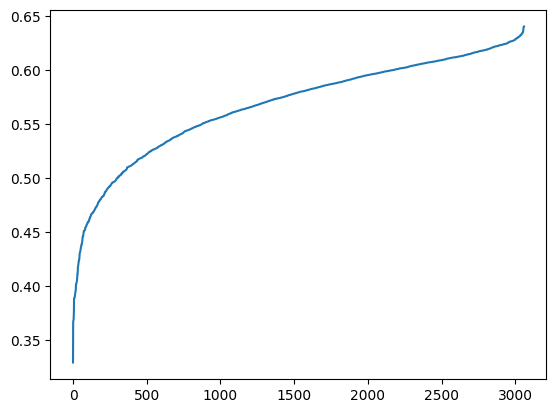

In [5]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = cyclists_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = cyclists_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [6]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

301

In [7]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,mean_cyclist_cp,mean_delta,mean_position,birth_year,weight,height,cyclist_bmi,isolation_forest_degree,isolation_forest_scores
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.0
mean,0.007936,561.384830,0.565979,1976.428571,68.380731,177.418605,21.653883,0.463242,1.0
std,0.017716,709.560621,0.230558,18.758262,10.283801,9.726126,2.189603,0.032529,0.0
min,0.000001,3.000000,0.044118,1940.000000,48.000000,154.000000,16.412069,0.329363,1.0
25%,0.000113,184.837838,0.386357,1961.000000,60.000000,170.000000,20.015496,0.451208,1.0
50%,0.001074,360.000000,0.539184,1981.000000,68.000000,177.000000,21.604938,0.471529,1.0
75%,0.005596,713.666667,0.746771,1991.000000,76.000000,184.000000,23.148148,0.488183,1.0
max,0.164538,7291.800000,1.000000,2004.000000,94.000000,204.000000,27.770313,0.499966,1.0


In [8]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/cyclists_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Races Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 2384 entries, 58 to 4927
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   points                2384 non-null   float64
 1   uci_points            2384 non-null   float64
 2   length                2384 non-null   float64
 3   climb_total           2384 non-null   float64
 4   profile               2384 non-null   float64
 5   startlist_quality     2384 non-null   int64  
 6   race_year             2384 non-null   int64  
 7   climb_percentage      2384 non-null   float64
 8   race_physical_effort  2384 non-null   float64
 9   race_prestige         2384 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 204.9 KB


<Axes: >

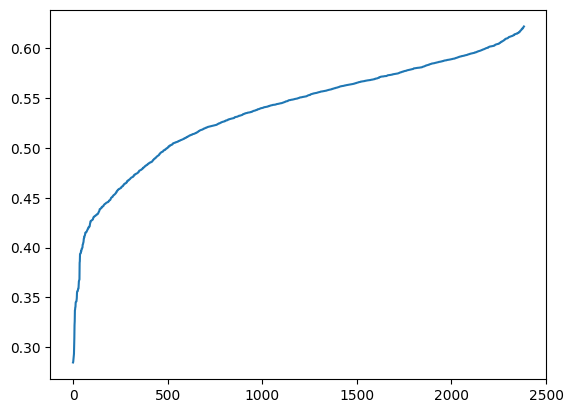

In [9]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = races_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = races_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [10]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

500

In [11]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,date,race_year,climb_percentage,race_physical_effort,race_prestige,isolation_forest_degree,isolation_forest_scores
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,160.520000,249.886000,171.842920,2.801192,2.904000,1092.444000,2013-12-08 10:01:55.200000256,2013.490000,0.027842,0.209472,0.266350,0.450516,1.0
min,20.000000,6.000000,1.900000,0.003000,1.000000,156.000000,2001-03-28 00:00:00,2001.000000,0.000191,0.000003,0.000000,0.284741,1.0
25%,80.000000,20.000000,127.250000,1.264000,2.000000,795.000000,2008-06-27 06:00:00,2008.000000,0.008317,0.033010,0.122013,0.433050,1.0
50%,100.000000,200.000000,200.500000,2.913500,2.000000,1002.000000,2014-12-24 12:00:00,2014.500000,0.016745,0.165653,0.265181,0.459482,1.0
75%,225.000000,500.000000,240.250000,4.245000,5.000000,1520.000000,2019-07-20 06:00:00,2019.000000,0.026087,0.318145,0.339177,0.480388,1.0
max,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,2023.000000,1.012105,0.895288,0.908128,0.499707,1.0
std,93.106752,214.520888,87.402906,1.774278,1.511076,406.462296,NaN,6.796638,0.077242,0.204851,0.161637,0.041317,0.0


In [12]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/races_dataset_no_outliers.csv', index=False)

## Anomaly Detection - Cyclist + Races Merged Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 348047 entries, 59 to 589737
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   birth_year                   348047 non-null  int64  
 1   weight                       348047 non-null  float64
 2   height                       348047 non-null  float64
 3   points                       348047 non-null  float64
 4   uci_points                   348047 non-null  float64
 5   length                       348047 non-null  float64
 6   climb_total                  348047 non-null  float64
 7   profile                      348047 non-null  float64
 8   startlist_quality            348047 non-null  int64  
 9   position                     348047 non-null  float64
 10  cyclist_age                  348047 non-null  int64  
 11  delta                        348047 non-null  float64
 12  race_year                    348047 non-null  int64  
 13  raw

<Axes: >

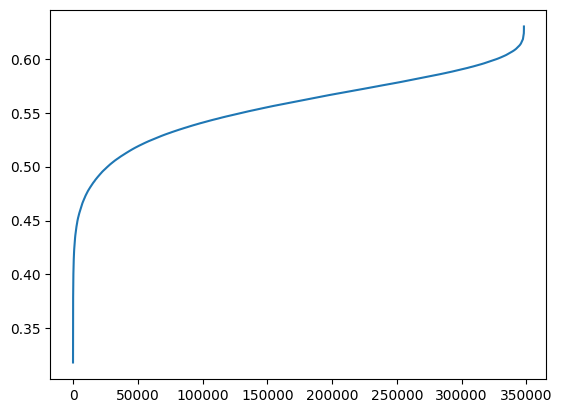

In [13]:
# Filter the dataset to keep only numeric and non-NaN rows
numeric_dataset = complete_dataset.select_dtypes(include=['number'])
numeric_dataset = numeric_dataset.dropna()
numeric_dataset.info()

max_features = numeric_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(numeric_dataset)

# Calculate outlier degrees and scores
outlier_degrees = algorithm.decision_function(numeric_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(numeric_dataset) + 1) / 2

# Combine with original dataset
dataset_with_outlier_scores = complete_dataset.copy()

# Initialize the new columns with NaN to match the original dataset's length
dataset_with_outlier_scores["isolation_forest_degree"] = float("nan")
dataset_with_outlier_scores["isolation_forest_scores"] = float("nan")

# Assign outlier scores only to the rows used in numeric_dataset
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_degree"] = outlier_degrees
dataset_with_outlier_scores.loc[numeric_dataset.index, "isolation_forest_scores"] = outlier_scores

# Plot sorted outlier degrees, with x matching its length
sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(len(sorted_outlier_degrees)),  # x-axis matches the length of sorted_outlier_degrees
    y=sorted_outlier_degrees
)

The outlier_degrees array provides a measure of how far each sample is from the decision boundary (the value is normalized):
- Close to 1: More likely to be an inlier.
- Close to 0: More likely to be an outlier.


The outlier_scores array represents a "binarized likelihood" of each data point being an outlier (scores values are 0 or 1):
- 1: More likely to be an outlier.
- 0: More likely to be an inlier.

In [14]:
degree_threshold = 0.5

# Combine thresholds for outlier detection
dataset_with_outlier_scores["is_outlier"] = (
    (dataset_with_outlier_scores["isolation_forest_scores"] == 1) &
    (dataset_with_outlier_scores["isolation_forest_degree"] < degree_threshold)
)

len(dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1])

26731

In [15]:
anomalies = dataset_with_outlier_scores[dataset_with_outlier_scores["is_outlier"] == 1]

anomalies.describe()

,birth_year,weight,height,points,uci_points,length,climb_total,profile,startlist_quality,date,...,race_prestige,mean_cyclist_cp,mean_delta,mean_position,previous_mean_position,previous_mean_delta,previous_mean_cp,cyclist_previous_experience,isolation_forest_degree,isolation_forest_scores
count,26731.000000,26731.00000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731,...,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.000000,26731.0
mean,1983.445251,69.33181,180.514496,166.633497,254.839587,198.171140,3.131153,3.006996,1113.194755,2013-06-04 15:14:16.937637888,...,0.285489,0.010510,475.100445,0.461236,0.463336,478.894590,0.013855,0.329754,0.474888,1.0
min,1963.000000,48.00000,158.000000,20.000000,6.000000,1.150000,0.002000,1.000000,156.000000,2001-03-03 00:00:00,...,0.000000,0.000002,38.142857,0.086467,0.008065,0.000000,0.000002,0.000185,0.318394,1.0
25%,1978.000000,64.00000,176.000000,80.000000,20.000000,175.500000,1.905000,2.000000,860.000000,2008-05-26 00:00:00,...,0.114472,0.001248,241.300537,0.323176,0.323299,225.137942,0.001096,0.084462,0.464065,1.0
50%,1983.000000,69.00000,180.000000,100.000000,120.000000,210.000000,3.220000,2.000000,1053.000000,2013-07-19 00:00:00,...,0.265181,0.003230,447.838565,0.471691,0.467397,415.153846,0.002575,0.258036,0.481068,1.0
75%,1989.000000,75.00000,185.000000,275.000000,500.000000,257.000000,4.443000,5.000000,1374.000000,2018-08-04 00:00:00,...,0.407872,0.011450,629.237013,0.587130,0.588898,602.020669,0.011908,0.522739,0.491821,1.0
max,2004.000000,94.00000,204.000000,350.000000,800.000000,305.000000,6.939000,5.000000,1812.000000,2023-07-29 00:00:00,...,0.908128,0.164538,7291.800000,0.993976,0.995968,13027.500000,0.606738,1.000000,0.499997,1.0
std,8.313765,7.32830,6.880355,102.601341,241.959821,76.098895,1.662805,1.530824,347.558506,NaN,...,0.186830,0.018825,318.194873,0.170758,0.175056,452.630468,0.032561,0.280378,0.022442,0.0


In [16]:
# The outliers found are now filtered from the dataset
dataset_with_outlier_scores = dataset_with_outlier_scores[dataset_with_outlier_scores['is_outlier'] != 1]

# Remove specified columns (used just during computation and analysis)
columns_to_remove = ['isolation_forest_scores', 'isolation_forest_degree', 'is_outlier']
final_dataset = dataset_with_outlier_scores.drop(columns=columns_to_remove)

# The dataset is now saved in csv format
final_dataset.to_csv('../data/complete_dataset_no_outliers.csv', index=False)